In [1]:
import re
import time
import requests
import selenium
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go

from bs4 import BeautifulSoup
from datetime import datetime
from selenium import webdriver
from sympy import symbols, solve
from plotly.subplots import make_subplots
from pandas_datareader import data as pdr
from selenium.webdriver.common.by import By
from forex_python.converter import CurrencyRates
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service as ChromeService

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

ticker = "TSLA"

In [2]:
yf.pdr_override()
tick = pdr.get_data_yahoo("TSLA", start = f"2014-03-31", end = None)

trading_days = len(tick)
tick.reset_index(inplace = True)
tick['Date'] = pd.to_datetime(tick['Date'])
tick['Delta'] = tick['Close'].pct_change() * 100
tick = tick.set_index('Date').resample('D').ffill().reset_index()

[*********************100%%**********************]  1 of 1 completed


In [3]:
##### Margin

options = Options()
options.add_argument('--headless')
options.add_argument('window-size = 800x600')
prefs = {"profile.managed_default_content_settings.images": 2}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options = options)

url = fr"https://stockanalysis.com/stocks/tsla/financials/?p=quarterly"
driver.get(url)
page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

## Date
date_all = []
date_parent = soup.find('th', string = "Quarter Ended").find_all_next('th')
for date in date_parent[:-1]:
    date_all.append(date.text)

## Revenue
rev_all = []
rev_parent = soup.find('a', string = "Revenue").find_parent('td').find_all_next('td')
for rev in rev_parent[:len(date_all)]:
    rev_all.append(float(re.sub(',', '', rev.text)))

## EPS
eps_all = []
eps_parent = soup.find('span', string = "EPS (Diluted)").find_parent('td').find_all_next('td')
for eps in eps_parent[:len(date_all)]:
    eps_all.append(float(eps.text))

## Gross Margin // Gross Profit = Revenue - Cost of Revenue
gross_margin_all = []    
gross_margin_parent = soup.find('span', string = "Gross Margin").find_parent('td').find_all_next('td')
for gross_margin in gross_margin_parent[:len(date_all)]:
    gross_margin_all.append(float(re.sub("%", "", gross_margin.text)))

## Operating Margin // Operating Profit = Revenue - Cost of Revenue - Operating Expenses
opt_margin_all = []
opt_margin_parent = soup.find('span', string = "Operating Margin").find_parent('td').find_all_next('td')
for opt_margin in opt_margin_parent[:len(date_all)]:
    opt_margin_all.append(float(re.sub("%", "", opt_margin.text)))

## Profit Margin // Net Income = Revenue - All expense
profit_margin_all = []
profit_margin_parent = soup.find('span', string = "Profit Margin").find_parent('td').find_all_next('td')
for profit_margin in profit_margin_parent[:len(date_all)]:
    profit_margin_all.append(float(re.sub("%", "", profit_margin.text)))

## Free Cash Flow Margin // Free Cash Flow = Operating Cash Flow - Capital Expenditures
fcf_margin_all = []
fcf_margin_parent = soup.find('span', string = "Free Cash Flow Margin").find_parent('td').find_all_next('td')
for fcf_margin in fcf_margin_parent[:len(date_all)]:
    fcf_margin_all.append(float(re.sub("%", "", fcf_margin.text)))

## EBITDA // EBITDA = Net Income + Interest + Taxes + Depreciation and Amortization
ebitda_margin_all = []
ebitda_margin_parent = soup.find('span', string = "EBITDA Margin").find_parent('td').find_all_next('td')
for ebitda_margin in ebitda_margin_parent[:len(date_all)]:
    ebitda_margin_all.append(float(re.sub("%", "", ebitda_margin.text)))

driver.quit()

In [4]:
##### Ratio
options = Options()
options.add_argument('--headless')
options.add_argument('window-size = 800x600')
prefs = {"profile.managed_default_content_settings.images": 2}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(options = options)

url = fr"https://stockanalysis.com/stocks/tsla/financials/ratios/?p=quarterly"
driver.get(url)
page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

## PE Ratio
pe_all = []
pe_parent = soup.find('span', string = "PE Ratio", ).find_parent('td').find_all_next('td')
for pe in pe_parent[1:len(date_all)+1]:
    pe_all.append(float(pe.text))

## PS Ratio
ps_all = []
ps_parent = soup.find('span', string = "PS Ratio", ).find_parent('td').find_all_next('td')
for ps in ps_parent[1:len(date_all)+1]:
    ps_all.append(float(ps.text))

## PB Ratio
pb_all = []
pb_parent = soup.find('span', string = "PB Ratio", ).find_parent('td').find_all_next('td')
for pb in pb_parent[1:len(date_all)+1]:
    pb_all.append(float(pb.text))

## Debt / Equity Ratio
de_all = []
de_parent = soup.find('span', string = "Debt / Equity Ratio").find_parent('td').find_all_next('td')
for de in de_parent[1:len(date_all)+1]:
    de_all.append(float(de.text))

## Quick Ratio
quick_all = []
quick_parent = soup.find('span', string = "Quick Ratio").find_parent('td').find_all_next('td')
for quick in quick_parent[1:len(date_all)+1]:
    quick_all.append(float(quick.text))

## Current Ratio
current_all = []
current_parent = soup.find('span', string = "Current Ratio").find_parent('td').find_all_next('td')
for current in current_parent[1:len(date_all)+1]:
    current_all.append(float(current.text))

driver.quit()

In [5]:
df = pd.DataFrame(list(zip(date_all, rev_all, eps_all , gross_margin_all, opt_margin_all, profit_margin_all, fcf_margin_all, ebitda_margin_all, pe_all, ps_all, pb_all, de_all, quick_all, current_all)), 
                  columns = ['Date', 'Revenue', 'EPS', 'Gross Margin (%)', 'Operating Margin (%)', 'Profit Margin (%)', 'Free Cash Flow Margin (%)', 'EBITDA Margin (%)', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'Debt / Equity Ratio', 'Quick Ratio', 'Current Ratio']
                  )
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = ['Date'], ignore_index = True, inplace = True)

In [6]:
d = pd.merge(df, tick[['Date', 'Close']], on = 'Date', how = 'left')
d

,Date,Revenue,EPS,Gross Margin (%),Operating Margin (%),Profit Margin (%),Free Cash Flow Margin (%),EBITDA Margin (%),PE Ratio,PS Ratio,PB Ratio,Debt / Equity Ratio,Quick Ratio,Current Ratio,Close
0,2014-03-31,620.54,-0.03,25.00,-7.09,-8.03,-13.32,1.15,-190.13,12.39,28.16,2.41,1.88,2.23,13.896667
1,2014-06-30,769.35,-0.03,27.69,-3.74,-8.05,-23.05,3.28,-178.96,12.23,31.28,2.57,1.77,2.18,16.004000
2,2014-09-30,851.80,-0.04,29.57,-4.59,-8.77,-36.65,2.71,-149.23,10.59,31.57,2.58,1.39,1.83,16.178667
3,2014-12-31,956.66,-0.06,27.36,-7.82,-11.25,-47.57,-0.76,-94.84,8.72,30.59,2.73,1.03,1.51,14.827333
4,2015-03-31,939.88,-0.08,27.67,-10.90,-16.40,-59.35,-5.05,-59.59,6.75,28.74,3.13,0.80,1.33,12.584667
5,2015-06-30,954.98,-0.10,22.34,-17.82,-19.29,-59.13,-6.84,-65.12,9.16,47.36,3.75,0.56,1.10,17.884001
6,2015-09-30,936.79,-0.12,24.71,-19.61,-24.54,-63.59,-9.44,-46.73,8.34,24.02,2.04,0.63,1.17,16.559999
7,2015-12-31,1214.00,-0.16,18.00,-21.44,-26.38,-36.32,-10.95,-35.37,7.77,29.00,2.49,0.49,0.99,16.000668
8,2016-03-31,1147.00,-0.14,22.01,-21.64,-24.61,-40.67,-7.09,-29.84,7.13,31.27,3.26,0.57,1.02,15.318000
9,2016-06-30,1270.00,-0.14,21.64,-18.74,-23.09,-11.37,-4.72,-25.26,6.22,11.28,1.30,0.93,1.38,14.152000


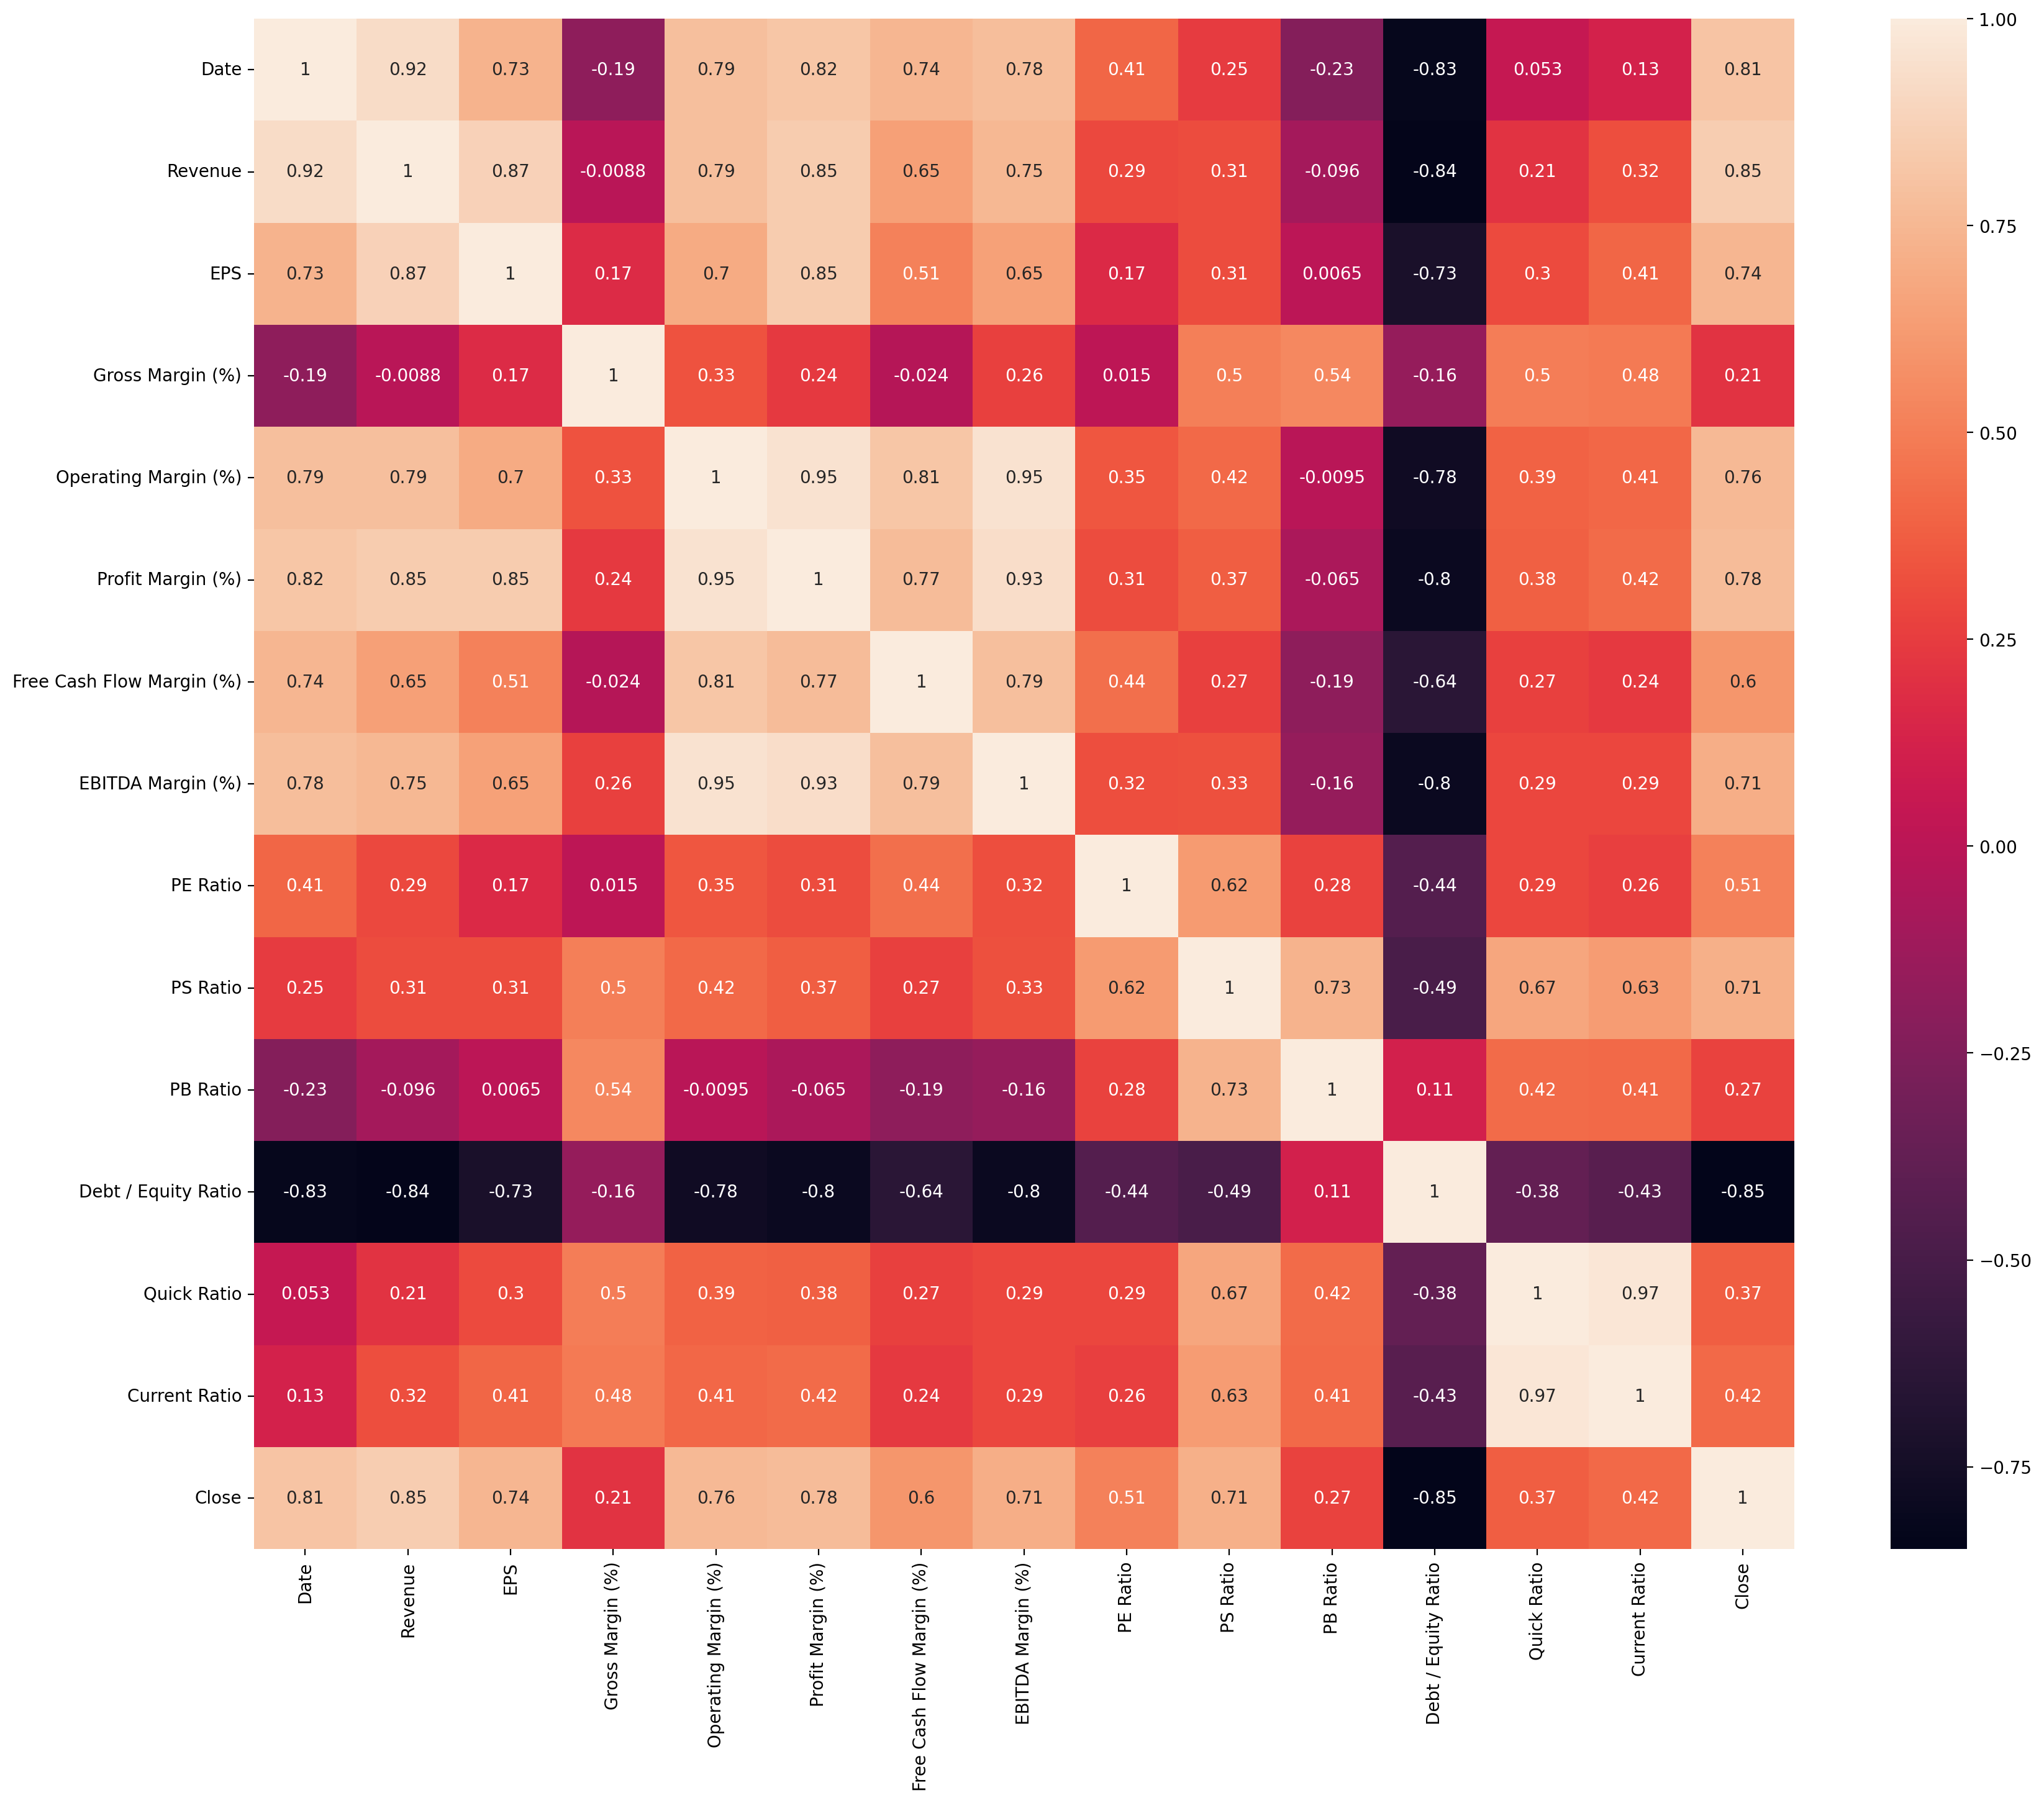

In [7]:
corr_matrix = d.corr()
plt.figure(figsize = (20, 16))
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [10]:
d = d[['Date', 'Revenue', 'EPS', 'Operating Margin (%)', 'Profit Margin (%)', 'EBITDA Margin (%)', 'PS Ratio', 'Debt / Equity Ratio']]
d.to_csv('./Financial Statement.csv')